In [ ]:
Librairies

In [5]:
import yfinance as yf
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, exp, log
from scipy.stats import norm
from numpy import mean, std
from random import gauss
import matplotlib.pyplot as plt
import warnings

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
warnings.simplefilter(action='ignore', category=FutureWarning)

B&S model for vailla option pricing

In [400]:
####### Model's parameters
S = 100
K = 105 
T = 150    # Time to maturity in days
t = T/250    # Time to maturity in years counting 250 trading days
r = 0.05
Vol = 0.20

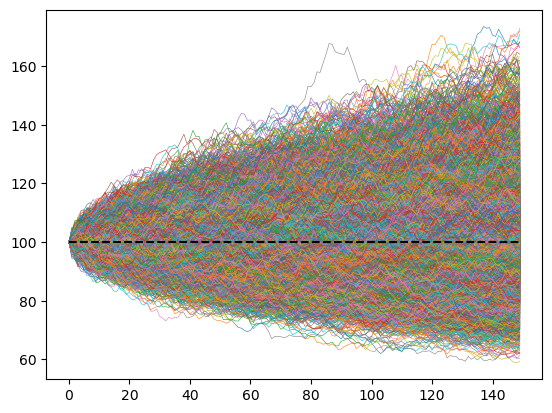

In [402]:
def Asset_difusion(Stock_price, rate, vol, dt) :
    # Using dSt = rSt*dt + Vol*dWt
    Increment =  Stock_price * ((rate * dt) + (vol * sqrt(dt) * np.random.normal(0, 1, 1)[0]))
    return(Stock_price + Increment)
    # Using the solution of the B&S asset's difusion
    # Stock_price *= exp((r - (vol**2)/2) * dt + vol * sqrt(dt) * np.random.normal(0, 1, 1)[0])
    # return(Stock_price)

# ####### Unique difusion
# Stock = [S]
# for i in range(1,T):
#     dt = t / T  # daily difusion
#     Stock.append(Actif_diffusion(Stock[i-1], r, vol, dt))

# pd.DataFrame(Stock).plot()
# plt.show()

####### Monte Carlo for price diffusion in the B&S model
Nombre_de_lancer = 10000

N_Stocks = [] 
for num_difu in range(0, Nombre_de_lancer) :
    Stock = [S]
    for i in range(1,T):
        dt = t / T  # daily difusion
        Stock.append(Asset_difusion(Stock[i-1], r, vol, dt))
    N_Stocks.append(Stock)

pd.DataFrame(N_Stocks).transpose().plot(linewidth =0.4)
plt.plot([S]*T, linestyle = 'dashed', color = "black")
plt.legend().remove()
plt.show()

European options 

European options
##################################################
Price of the call :
using the Monte Carlo method :  5.425883070869003
For the B&S formula :  5.330074167762987
Difference beetween the 2 methods : -0.09580890310601564
##################################################
Price of the put :
using the Monte Carlo method :  7.093157426826976
For the B&S formula :  7.226855190356346
Difference beetween the 2 methods : 0.13369776352937013
##################################################




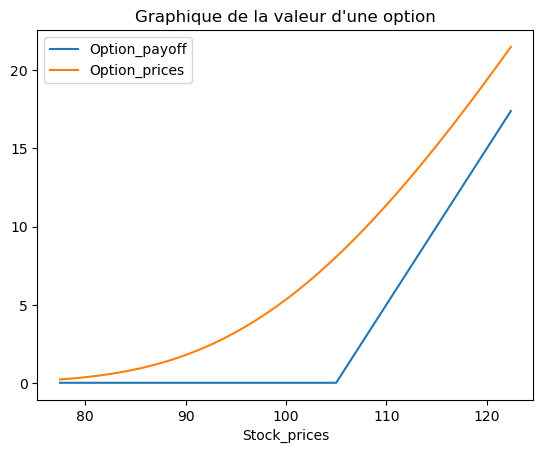

In [404]:
Final_prices = pd.DataFrame(N_Stocks).transpose().loc[T - 1]

## In continuous time and trading for 250 days within a year
Call_Payoff = [max(x - K, 0) for x in Final_prices]
Put_Payoff = [max(K - x, 0) for x in Final_prices]

Call_Price_Monte_Carlo = mean(Call_Payoff) * exp(-r*t)
Put_Price_Monte_Carlo =  mean(Put_Payoff) * exp(-r*t)

##### B&S's closed formula
d1 = (log(S/K) + (r + (Vol**2)/2) * t) / (vol * sqrt(t))
d2 = d1 - Vol * sqrt(t)

Call_Price_static = S*norm.cdf(d1) - K*exp(-r*t)*norm.cdf(d2)
Put_Price_static = K*exp(-r*t)*norm.cdf(-d2) - S*norm.cdf(-d1)

print("European options")
print("#" * 50)
print("Price of the call :")
print("using the Monte Carlo method : ", Call_Price_Monte_Carlo)
print("For the B&S formula : ", Call_Price_static)
print("Difference beetween the 2 methods :", Call_Price_static - Call_Price_Monte_Carlo)
print("#" * 50)
print("Price of the put :")
print("using the Monte Carlo method : ", Put_Price_Monte_Carlo)
print("For the B&S formula : ", Put_Price_static)
print("Difference beetween the 2 methods :", Put_Price_static - Put_Price_Monte_Carlo)
print("#" * 50)
print("\n" )

## Graphs for the option value (intrinsic and payoff)
Options = {"Stock_prices" : [], "Option_payoff" : [], "Option_prices" : []}
Options["Stock_prices"] = [S + i/10.0 for i in range(-round(np.log(T) * 45), round(np.log(T)) * 45, 1)]
# We use this technic in order to make small incrementes of S, if not we get cases where the payoff function is not linear after K 
# One can try using : Options["Stock_prices"] = [i for i in range(S-20, S+20, 1)]
Options["Option_payoff"] = [max(i - K, 0) for i in Options["Stock_prices"]]

for Stock_price in Options["Stock_prices"] : 
    d1_price = (log(Stock_price/K) + (r + (vol**2)/2) * t) / (Vol * sqrt(t))
    d2_price = d1_price - Vol * sqrt(t)
    Options["Option_prices"].append(Stock_price*norm.cdf(d1_price) - K*exp(-r*t)*norm.cdf(d2_price))
    
pd.DataFrame(Options).set_index("Stock_prices").plot(title = "Graphique de la valeur d'une option") 
plt.show()

The Grecks - computed for a maturity of 150 days (the option's market rarely takes maturity up to a year, 1 to 6 months in general)

##################################################
Les grecques
Delta :  0.3998681752986035
Gamma :  0.03526503594808256
Vega :  0.2115902156884953
Theta :  -0.05200374880089222
Rho :  0.11115793857163733
##################################################


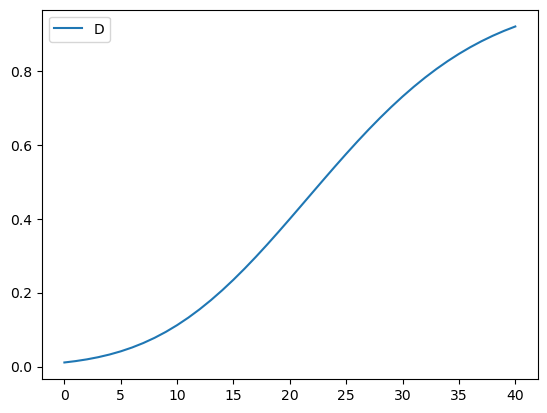

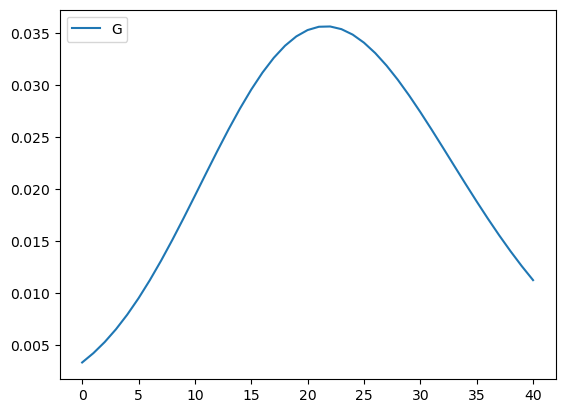

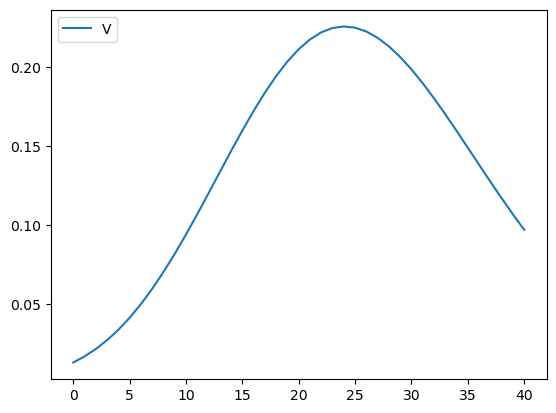

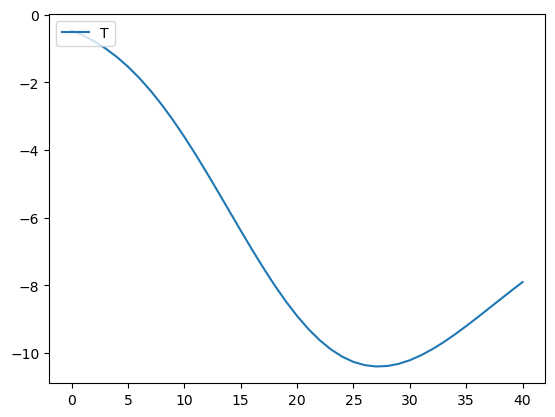

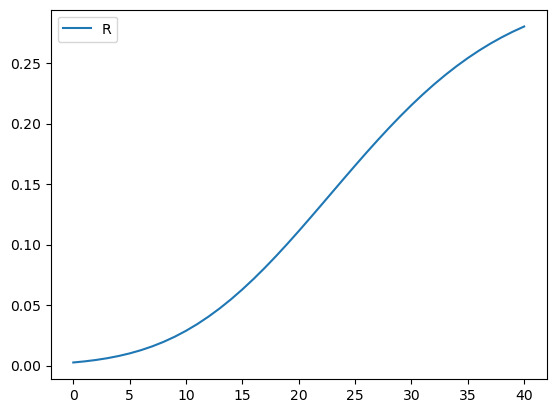

In [406]:
T = 75    # Time to maturity in days
t = T/250    # Time to maturity in years counting 250 trading days

##### B&S's closed formula
d1_greck = (log(S/K) + (r + (Vol**2)/2) * t) / (vol * sqrt(t))
d2_greck = d1_greck - Vol * sqrt(t)

Delta = norm.cdf(d1_greck)
Gamma = norm.pdf(d1_greck) / (S * Vol * sqrt(t))
Vega = S * norm.pdf(d1_greck) * sqrt(t)
Theta = ((- S * norm.pdf(d1_greck) * Vol) / (2*sqrt(t))) + r * K*exp(-r*t) * norm.cdf(d2_greck)
Rho = t * K * exp(-r*t) * norm.cdf(d2_greck)

print("#" * 50)
print("Les grecques")
print("Delta : ", Delta)
print("Gamma : ", Gamma)
print("Vega : ", Vega/100)
print("Theta : ", Theta/100)
print("Rho : ", Rho/100)
print("#" * 50)
## Remarque : le vega, le theta et le rho sortent en % dans les formules de B&S

## Graphs for the grecks
Grecks = {"Deltas" : [], "Gammas" : [], "Vegas" : [], "Thetas" : [], "Rhos" : []}
S_grecks = [i for i in range(S-20, S+21, 1)]

for S_greck in S_grecks : 
    d1_grecks = (log(S_greck/K) + (r + (Vol**2)/2) * t) / (vol * sqrt(t))
    d2_grecks = d1_grecks - Vol * sqrt(t)
    
    Grecks["Deltas"].append(norm.cdf(d1_grecks))
    Grecks["Gammas"].append(norm.pdf(d1_grecks) / (S_greck * vol * sqrt(t)))
    Grecks["Vegas"].append(S_greck * norm.pdf(d1_grecks) * sqrt(t)/100)
    Grecks["Thetas"].append(-((S_greck * norm.pdf(d1_grecks) * vol) / (2*sqrt(t))) - r*K*exp(-r*t)*norm.cdf(d2_grecks))
    Grecks["Rhos"].append(t * K * exp(-r*t) * norm.cdf(d2_grecks)/100)
    
for greck in Grecks.keys() :
    pd.DataFrame(Grecks[greck]).plot() 
    plt.legend(greck, loc = "upper left")
    plt.show()

Asian options -- In progress

In [410]:
# 
Call_Payoff = [max(mean(x) - K, 0) for x in N_Stocks]
Put_Payoff = [max(K - mean(x), 0) for x in N_Stocks]

Asian_Call_Price_Monte_Carlo = mean(Call_Payoff) * exp(-r*t)
Asian_Put_Price_Monte_Carlo =  mean(Put_Payoff) * exp(-r*t)

print("Asian options")
print("#" * 30)
print("Price of the call :")
print("using the Monte Carlo method : ", Asian_Call_Price_Monte_Carlo)
print("Price of the put :")
print("using the Monte Carlo method : ", Asian_Put_Price_Monte_Carlo)
print("\n" * 3)

Asian options
##############################
Price of the call :
using the Monte Carlo method :  2.212649240788799
Price of the put :
using the Monte Carlo method :  5.544358300383105






In [430]:
def Asset_difusion(Stock_price, rate, vol, day_t, X_normal_vars, dt) :    
    X1_normal = X_normal_vars[0]
    # Using dSt = rSt*dt + Vol*dW1t
    Increment_stock =  Stock_price * ((rate * dt) + (vol * sqrt(dt) * X1_normal))
    return(Stock_price + Increment_stock)
    
def Volatility_difusion(vol_t, Kappa, alpha, beta, X_normal_vars, dt) :
    X2_normal = X_normal_vars[1]
    # Using dVt = kappa*(alpha - Vt^2)*dt + beta*Vt*dW2t
    Increment_vol =  (Kappa * (alpha - vol_t**2) * dt + (beta * vol_t * sqrt(dt) * X2_normal))
    return(sqrt(max(vol_t**2 + Increment_vol, 0))) # Since you cannot pass a negative argument in the square root function

In [470]:
# Variables regarding the asset's difusion process
S = 100
K = 100 * exp(-r*t)
T = 250    # Time to maturity in days
t = T/250    # Time to maturity in years counting 250 trading days
r = 0.05
Vol = 0.15

# Variables regarding the volatility's difusion process
Mean_brownian_motions = [0, 0]
Cov_brownian_motions = 0.80
Mat_Var_Cov = [[1, Cov_brownian_motions], 
               [Cov_brownian_motions, 1]]
Kappa = 0.8  # niveau de retour à la moyenne rapide
alpha = 0.2 # niveau moyen de vol à 20%
beta = 0.3   # Volatilité de la volatilité 

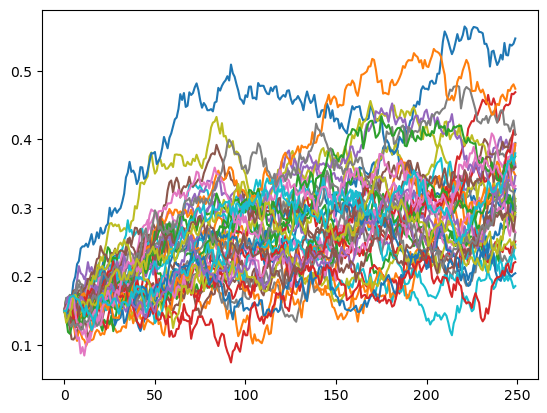

In [472]:
Nombre_de_lancer = 40
N_Stocks = [] 
N_Vts = [] 

for num_difu in range(0, Nombre_de_lancer) :
    Stock = [S]
    Vt = [Vol]
    for day in range(1,T):
        dt = 1 / T   # daily difusion
        # At each step we draw a 2 dimensional normal value with the covariance specified above 
        X_normal_vars = np.random.multivariate_normal(Mean_brownian_motions, Mat_Var_Cov)
        
        Vt.append(Volatility_difusion(Vt[day-1], Kappa, alpha, beta, X_normal_vars, dt))
        Stock.append(Asset_difusion(Stock[day-1], r, Vt[day], day, X_normal_vars, dt))
    N_Stocks.append(Stock)
    N_Vts.append(Vt)

pd.DataFrame(N_Vts).transpose().plot() 
plt.legend().remove()
plt.show()